In [ ]:
%%javascript
  function ClickConnect() {
    var iconElement = document.getElementById("toggle-header-button");
    if (iconElement) {
    var clickEvent = new MouseEvent ("click", {
        bubbles: true, cancelable: true,
        view: window
      });
    iconElement.dispatchEvent (clickEvent);
    }
  }
  setInterval(ClickConnect, 6000);

<IPython.core.display.Javascript object>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import random
from torch.utils.data import Dataset, DataLoader
#import torch_xla.core.xla_model as xm
#import torch_xla
from PIL import Image
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "xla" if xm.xla_device() else "cpu")

Mounted at /content/drive


# ***Creación del Modelo***

In [ ]:
def cargarDataset(ruta_dataset, guardar_ruta, tamanio_imagen=(300, 300), test_size=0.2, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = []
    etiquetas_mapping = {}
    clases = sorted(os.listdir(ruta_dataset))
    etiquetas_mapping = {clase: idx for idx, clase in enumerate(clases)}
    for clase in clases:
        ruta_clase = os.path.join(ruta_dataset, clase)
        etiqueta_num = etiquetas_mapping[clase]
        with os.scandir(ruta_clase) as entries:
            for entry in entries:
                if entry.is_file():
                    imagen_ruta = os.path.join(ruta_clase, entry.name)
                    imagen = Image.open(imagen_ruta).convert('RGB')
                    imagen_resized = imagen.resize(tamanio_imagen)
                    imagen_array = np.array(imagen_resized) / 255.0
                    imagen_tensor = torch.tensor(imagen_array).float().permute(2, 0, 1).to(device)
                    dataset.append((imagen_tensor, etiqueta_num))
    random.shuffle(dataset)
    torch.save(dataset, guardar_ruta)
    return dataset
def mostrarGraficoEvaluacion(hist):
    fig = plt.figure(dpi=200, figsize=(10, 3))
    ax = plt.subplot(121)
    pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
    ax = plt.subplot(122)
    pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
    plt.show()
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1, keepdims=True)
def calcularEstadisticas(dataset, device):
    suma = torch.zeros(3, device=device)
    suma_cuadrada = torch.zeros(3, device=device)
    total_imagenes = 0
    for img, _ in dataset:
        img = img.to(device)
        suma += img.sum(dim=(1, 2))
        suma_cuadrada += (img ** 2).sum(dim=(1, 2))
        total_imagenes += img.shape[1] * img.shape[2]
    media = suma / total_imagenes
    varianza = (suma_cuadrada / total_imagenes) - (media ** 2)
    desviacion_estandar = torch.sqrt(varianza)
    return media, desviacion_estandar

In [ ]:
class MLP(nn.Sequential):
    def __init__(self, capa_entrada, capa_oculta, capa_salida, probabilidad_dropout):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(capa_entrada, capa_oculta)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(probabilidad_dropout)
        self.layer2 = nn.Linear(capa_oculta, capa_oculta)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(probabilidad_dropout)
        self.layer3 = nn.Linear(capa_oculta, capa_salida)
    def entrenar(self, dataloader, optimizer, scheduler=None, epochs=0, log_each=10, early_stopping=0, criterion=nn.CrossEntropyLoss(), ruta_guardar_modelo='ckpt.pt'):
        hist = {'epoch': [], 'loss': [], 'acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
        best_acc, step = 0, 0
        torch.save(self.state_dict(), ruta_guardar_modelo)
        for e in range(1, epochs + 1):
            self.train()
            train_loss, train_acc, _, _ = self._correrEpoch(dataloader['train'], optimizer, criterion)
            self.eval()
            val_loss, val_acc, _, _ = self._correrEpoch(dataloader['test'], optimizer=None, criterion=criterion, evaluar=True)
            hist['epoch'].append(e)
            hist['loss'].append(train_loss)
            hist['acc'].append(train_acc)
            hist['val_loss'].append(val_loss)
            hist['val_acc'].append(val_acc)
            hist['lr'].append(optimizer.param_groups[0]['lr'])
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(self.state_dict(), ruta_guardar_modelo)
                step = 0
                print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
            else:
                step += 1
            if scheduler:
                scheduler.step()
            if early_stopping and step > early_stopping:
                print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
                break
            if e % log_each == 0:
                print(f"Epoch {e}/{epochs} loss {train_loss:.5f} acc {train_acc:.5f} val_loss {val_loss:.5f} val_acc {val_acc:.5f} lr {hist['lr'][-1]:.5f}")
        #self.load_state_dict(torch.load(ruta_guardar_modelo))
        return hist
    def _correrEpoch(self, dataloader, optimizer, criterion, evaluar=False):
        total_loss, total_acc, total_muestras = 0, 0, 0
        all_labels, all_preds = [], []
        for x_b, y_b in dataloader:
            x_b, y_b = x_b.to(device), y_b.to(device)
            x_b = x_b.view(x_b.size(0), -1)
            if y_b.ndim != 1:
                y_b = y_b.view(-1)
            y_pred = self(x_b)
            loss = criterion(y_pred, y_b)
            if not evaluar:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * x_b.size(0)
            _, y_probas = torch.max(y_pred, 1)
            total_acc += (y_probas == y_b).sum().item()
            total_muestras += x_b.size(0)
            all_labels.extend(y_b.cpu().numpy())
            all_preds.extend(y_probas.cpu().numpy())
        avg_loss = total_loss / total_muestras
        accuracy = total_acc / total_muestras
        return avg_loss, accuracy, all_labels, all_preds
    def evaluarModelo(self, dataloader, criterio):
        self.eval()
        accuracy, avg_loss, all_labels, all_preds = self._correrEpoch(dataloader, optimizer=None, criterion=criterio, evaluar=True)
        print(f"Precisión: {accuracy:.4f}, Pérdida promedio: {avg_loss:.4f}")
        return accuracy, avg_loss, all_labels, all_preds
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.layer3(x)
        return x

# ***Exploración de Datos***

In [ ]:
ruta_guardar_dataset = '/content/drive/MyDrive/SIS421/Laboratorio N°2 - SIS421/checkpoints/dataset.pt'
ruta_guardar_modelo = '/content/drive/MyDrive/SIS421/Laboratorio N°2 - SIS421/checkpoints/modelo.pt'
ruta_dataset = '/content/drive/MyDrive/SIS421/Laboratorio N°2 - SIS421/Plantas'
dataset = cargarDataset(ruta_dataset, guardar_ruta=ruta_guardar_dataset, device=device)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

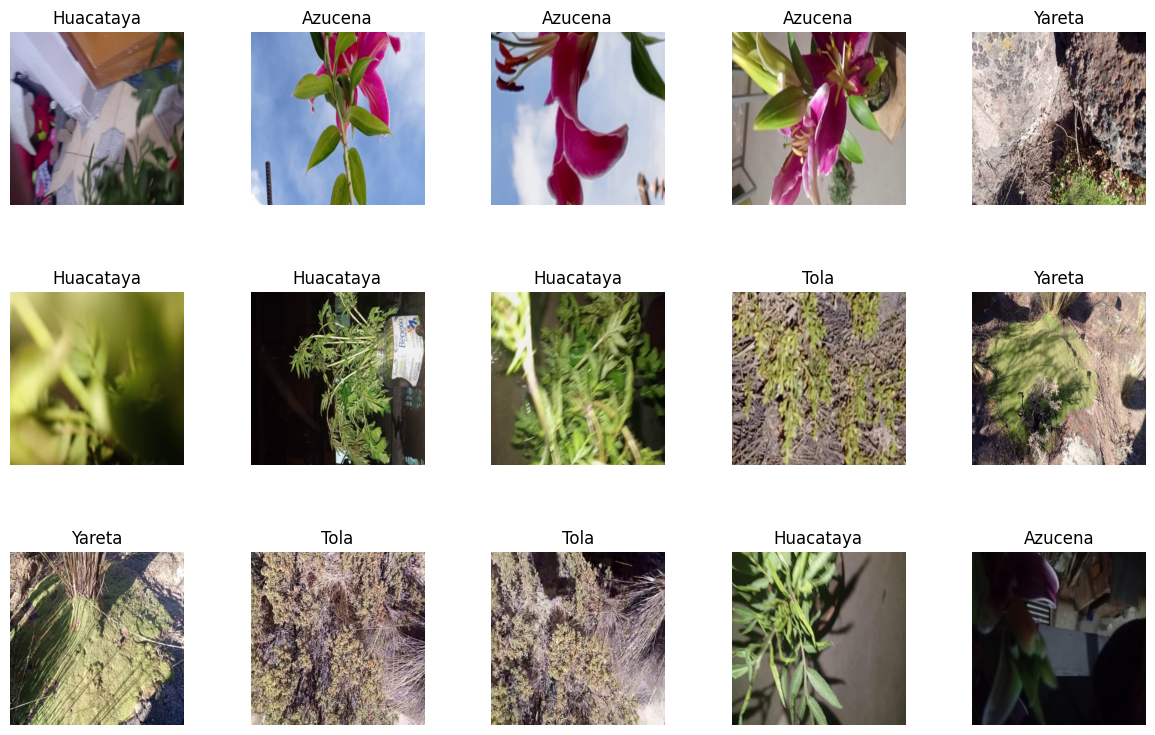

In [ ]:
# Visualización de imágenes
classes = ('Azucena', 'Huacataya', 'Kantuta', 'Tola', 'Yareta')
filas, columnas = 3, 5
plt.figure(figsize=(columnas*3, filas*3))
for fila in range(filas):
    for columna in range(columnas):
        indice = columnas*fila + columna
        plt.subplot(filas, columnas, indice + 1)
        ix = random.randint(0, len(train_dataset)-1)
        img, etiqueta = train_dataset[ix]
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title(classes[etiqueta])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Media: tensor([0.4552, 0.4286, 0.3657], device='cuda:0')
Desviación estándar: tensor([0.2558, 0.2551, 0.2470], device='cuda:0')


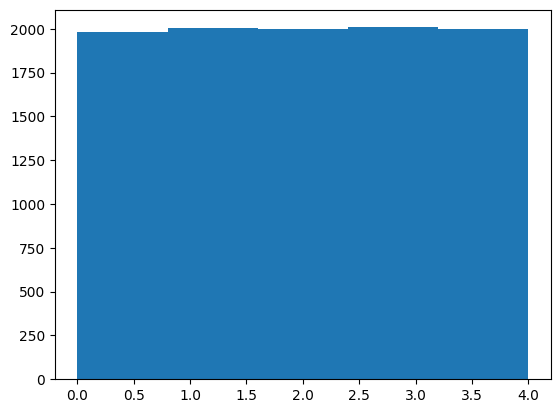

Etiquetas únicas: [0 1 2 3 4]
Conteos: [1981 2003 1999 2008 1999]


In [ ]:
# Estadísticas de las imágenes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
media, desviacion_estandar = calcularEstadisticas(train_dataset, device)

print("Media:", media)
print("Desviación estándar:", desviacion_estandar)

# Histograma de etiquetas
etiquetas_entrenamiento = [etiqueta for _, etiqueta in train_dataset]
plt.hist(etiquetas_entrenamiento, bins=len(classes))
plt.show()

unicos, conteos = torch.unique(torch.tensor(etiquetas_entrenamiento, device=device), return_counts=True)
print("Etiquetas únicas:", unicos.cpu().numpy())
print("Conteos:", conteos.cpu().numpy())

# ***Entrenamiento del Modelo***

In [ ]:
#Verificar las dimensiones del Modelo
dimension_entrada = 300 * 300 * 3
dimension_oculta = 128
dimension_salida = 5
dropout_probabilidad = 0.1
modelo = MLP(dimension_entrada, dimension_oculta, dimension_salida, dropout_probabilidad).to(device)
x = torch.randn(64, dimension_entrada).to(device)
output = modelo(x)
print("Dimensión de salida:", output.shape)

Dimensión de salida: torch.Size([64, 5])


In [ ]:
criterio = torch.nn.CrossEntropyLoss()

In [ ]:
# Verificar la forma del tensor de entrada
single_sample, single_label = dataset[0]
print("Forma original de la muestra:", single_sample.shape)

# Redimensionar correctamente
single_sample = single_sample.reshape(1, -1)
print("Forma después de aplanar:", single_sample.shape)

Forma original de la muestra: torch.Size([3, 300, 300])
Forma después de aplanar: torch.Size([1, 270000])


In [ ]:
# Configuración 1: Entrenamiento con una muestra simple
single_sample, single_label = dataset[0]
single_sample = single_sample.reshape(1, -1)
single_label = torch.tensor([single_label])
single_loader = {
    'train': DataLoader([(single_sample, single_label)], batch_size=1),
    'test': DataLoader([(single_sample, single_label)], batch_size=1)
}
optimizer = torch.optim.SGD(modelo.parameters(), lr=0.001)
hist = modelo.entrenar(single_loader, optimizer, epochs=5, log_each=1, criterion=criterio, ruta_guardar_modelo='model_single.pt')
accuracy, avg_loss, all_labels, all_preds = modelo.evaluarModelo(single_loader['test'], criterio)
print(f"Precisión con una sola muestra: {accuracy:.4f}, Pérdida promedio: {avg_loss:.4f}")


Mejor modelo guardado con acc 1.00000 en epoch 1
Epoch 1/5 loss 1.73103 acc 0.00000 val_loss 1.39407 val_acc 1.00000 lr 0.00100
Epoch 2/5 loss 1.25640 acc 1.00000 val_loss 1.01065 val_acc 1.00000 lr 0.00100
Epoch 3/5 loss 0.93583 acc 1.00000 val_loss 0.81900 val_acc 1.00000 lr 0.00100
Epoch 4/5 loss 1.12854 acc 1.00000 val_loss 0.68637 val_acc 1.00000 lr 0.00100
Epoch 5/5 loss 0.64835 acc 1.00000 val_loss 0.52175 val_acc 1.00000 lr 0.00100
Precisión: 1.3941, Pérdida promedio: 1.0000
Precisión con una sola muestra: 1.3941, Pérdida promedio: 1.0000


<ipython-input-4-5385c8cf7563>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(ruta_guardar_modelo))


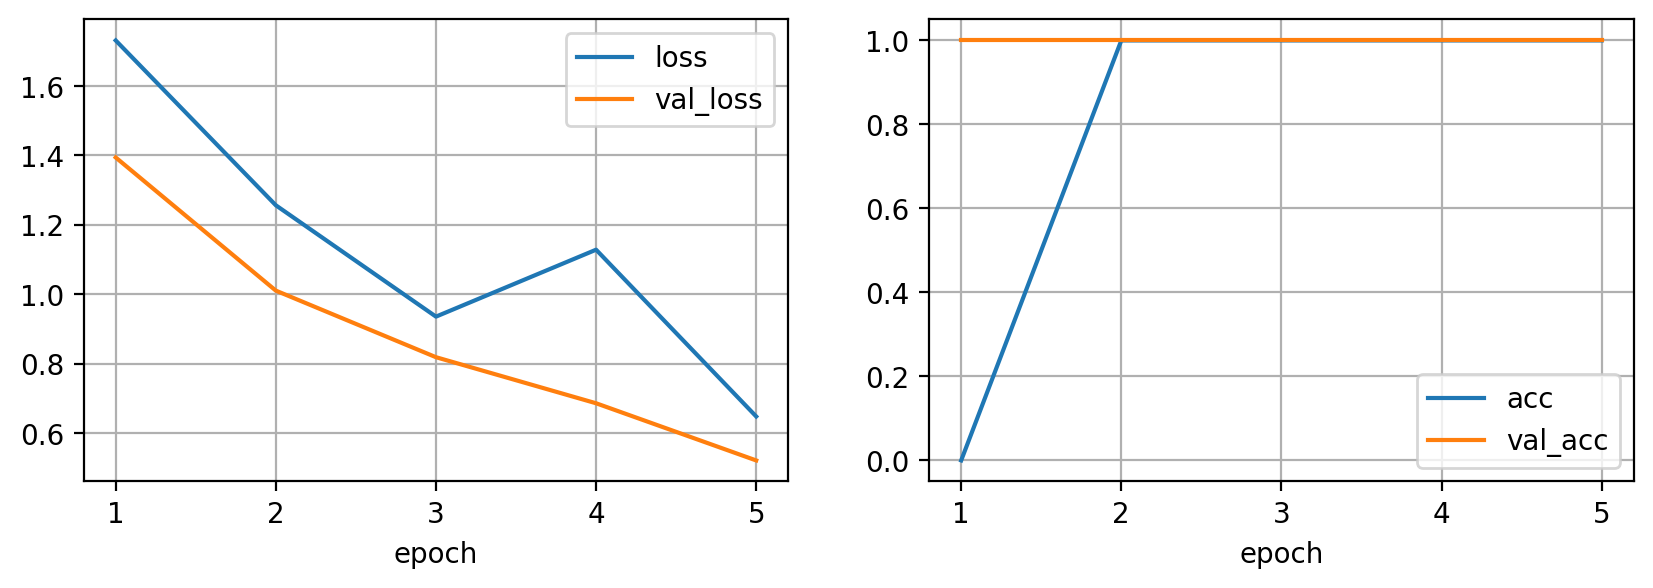

In [ ]:
mostrarGraficoEvaluacion(hist)

In [ ]:
# Configuración 2: Entrenamiento con un batch de 32 imágenes
batch_size = 32
batch_loader = {
    'train': DataLoader(dataset[:batch_size], batch_size=batch_size),
    'test': DataLoader(dataset[:batch_size], batch_size=batch_size)
}
hist = modelo.entrenar(batch_loader, optimizer, epochs=5, log_each=1, criterion=criterio, ruta_guardar_modelo='model_batch.pt')
accuracy, avg_loss, all_labels, all_preds = modelo.evaluarModelo(batch_loader['test'], criterio)
print(f"Precisión con un batch: {accuracy:.4f}, Pérdida promedio: {avg_loss:.4f}")

Mejor modelo guardado con acc 0.25000 en epoch 1
Epoch 1/5 loss 1.62560 acc 0.12500 val_loss 1.59953 val_acc 0.25000 lr 0.00100
Epoch 2/5 loss 1.59522 acc 0.21875 val_loss 1.58862 val_acc 0.25000 lr 0.00100
Epoch 3/5 loss 1.58702 acc 0.12500 val_loss 1.58078 val_acc 0.25000 lr 0.00100
Epoch 4/5 loss 1.59508 acc 0.21875 val_loss 1.57073 val_acc 0.25000 lr 0.00100
Mejor modelo guardado con acc 0.31250 en epoch 5
Epoch 5/5 loss 1.58090 acc 0.21875 val_loss 1.56075 val_acc 0.31250 lr 0.00100


<ipython-input-4-5385c8cf7563>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(ruta_guardar_modelo))


Precisión: 1.5607, Pérdida promedio: 0.3125
Precisión con un batch: 1.5607, Pérdida promedio: 0.3125


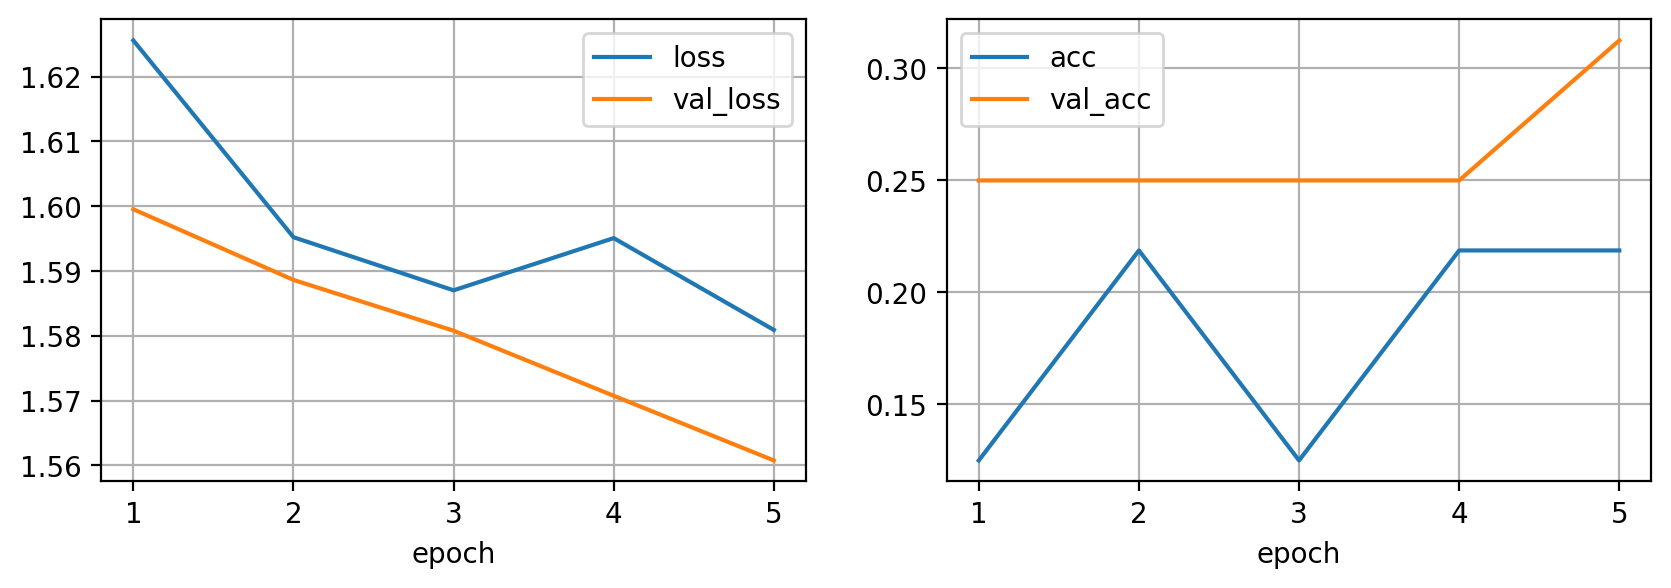

In [ ]:
mostrarGraficoEvaluacion(hist)

In [ ]:
# Configuración 3: Entrenamiento con un subconjunto del dataset
subset_size = int(len(dataset) * 0.1)
subset_loader = {
    'train': DataLoader(dataset[:subset_size], batch_size=batch_size),
    'test': DataLoader(dataset[:subset_size], batch_size=batch_size)
}
hist = modelo.entrenar(subset_loader, optimizer, epochs=100, log_each=10, criterion=criterio, ruta_guardar_modelo='model_subset.pt')
accuracy, avg_loss, all_labels, all_preds = modelo.evaluarModelo(subset_loader['test'], criterio)
print(f"Precisión con un subconjunto: {accuracy:.4f}, Pérdida promedio: {avg_loss:.4f}")


Mejor modelo guardado con acc 0.25801 en epoch 1
Mejor modelo guardado con acc 0.30288 en epoch 2
Mejor modelo guardado con acc 0.34135 en epoch 3
Mejor modelo guardado con acc 0.34455 en epoch 4
Mejor modelo guardado con acc 0.37580 en epoch 5
Mejor modelo guardado con acc 0.42067 en epoch 6
Mejor modelo guardado con acc 0.42708 en epoch 8
Mejor modelo guardado con acc 0.43830 en epoch 9
Mejor modelo guardado con acc 0.45673 en epoch 10
Epoch 10/100 loss 1.45208 acc 0.41346 val_loss 1.42441 val_acc 0.45673 lr 0.00100
Mejor modelo guardado con acc 0.47276 en epoch 11
Mejor modelo guardado con acc 0.48077 en epoch 12
Mejor modelo guardado con acc 0.48558 en epoch 13
Mejor modelo guardado con acc 0.50801 en epoch 14
Mejor modelo guardado con acc 0.53365 en epoch 15
Mejor modelo guardado con acc 0.54808 en epoch 17
Mejor modelo guardado con acc 0.55609 en epoch 19
Epoch 20/100 loss 1.23993 acc 0.54167 val_loss 1.20797 val_acc 0.55128 lr 0.00100
Mejor modelo guardado con acc 0.56170 en epo

<ipython-input-4-5385c8cf7563>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(ruta_guardar_modelo))


Precisión: 0.2523, Pérdida promedio: 0.9776
Precisión con un subconjunto: 0.2523, Pérdida promedio: 0.9776


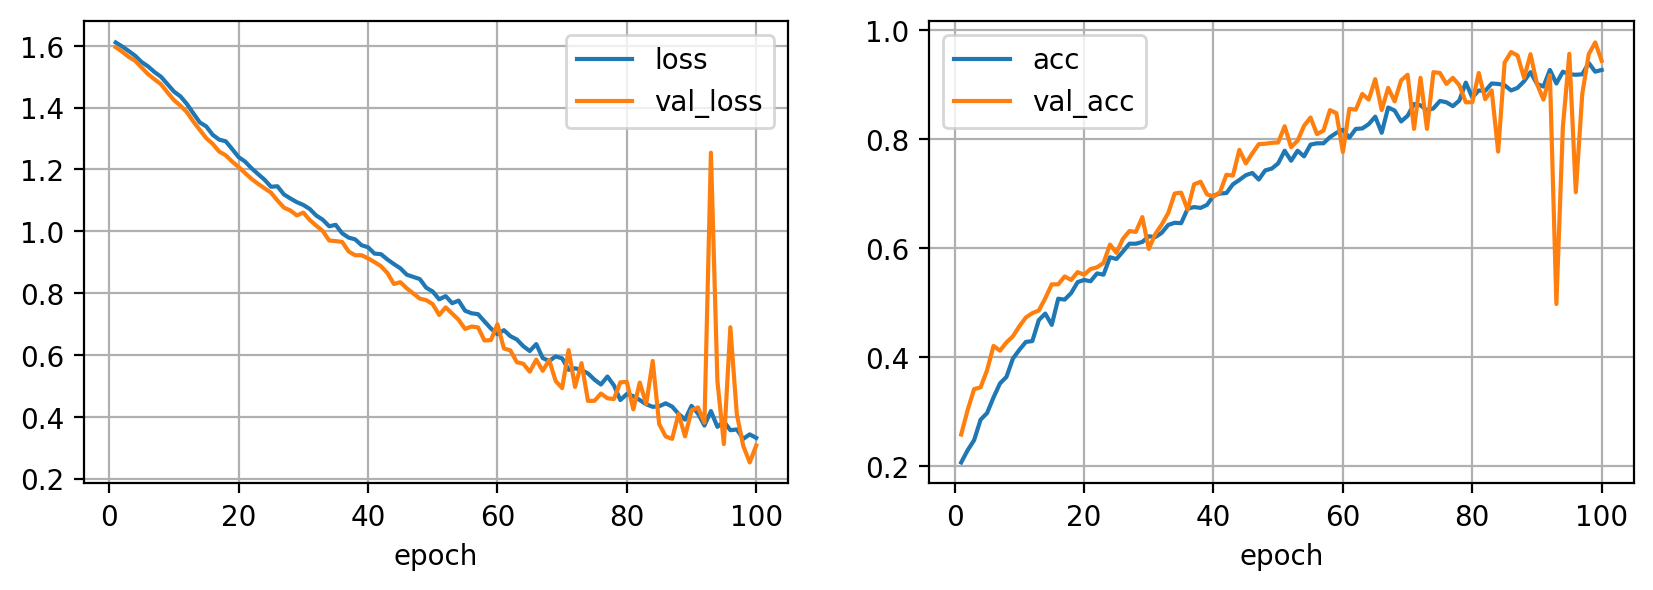

In [ ]:
mostrarGraficoEvaluacion(hist)

In [ ]:
# Configuración 4: Entrenamiento con el dataset completo
full_loader = {
    'train': DataLoader(dataset, batch_size=batch_size),
    'test': DataLoader(dataset, batch_size=batch_size)
}
optimizer = torch.optim.SGD(modelo.parameters(), lr=0.001)  # Re-inicializar el optimizador
hist = modelo.entrenar(full_loader, optimizer, epochs=1000, log_each=100, criterion=criterio, ruta_guardar_modelo='/content/drive/MyDrive/SIS421/Laboratorio N°2 - SIS421/checkpoints/modelo.pt')
accuracy, avg_loss, all_labels, all_preds = modelo.evaluarModelo(full_loader['test'], criterio)
print(f"Precisión con todo el dataset: {accuracy:.4f}, Pérdida promedio: {avg_loss:.4f}")

Mejor modelo guardado con acc 0.38157 en epoch 1
Mejor modelo guardado con acc 0.42064 en epoch 2
Mejor modelo guardado con acc 0.44739 en epoch 3
Mejor modelo guardado con acc 0.51425 en epoch 4
Mejor modelo guardado con acc 0.52578 en epoch 5
Mejor modelo guardado con acc 0.54340 en epoch 6
Mejor modelo guardado con acc 0.56783 en epoch 7
Mejor modelo guardado con acc 0.58272 en epoch 10
Mejor modelo guardado con acc 0.60666 en epoch 11
Mejor modelo guardado con acc 0.63029 en epoch 12
Mejor modelo guardado con acc 0.67016 en epoch 15
Mejor modelo guardado con acc 0.68818 en epoch 18
Mejor modelo guardado con acc 0.70340 en epoch 19
Mejor modelo guardado con acc 0.71212 en epoch 21
Mejor modelo guardado con acc 0.71357 en epoch 22
Mejor modelo guardado con acc 0.73631 en epoch 23
Mejor modelo guardado con acc 0.73687 en epoch 24
Mejor modelo guardado con acc 0.75152 en epoch 25
Mejor modelo guardado con acc 0.75585 en epoch 26
Mejor modelo guardado con acc 0.77130 en epoch 27
Mejor m

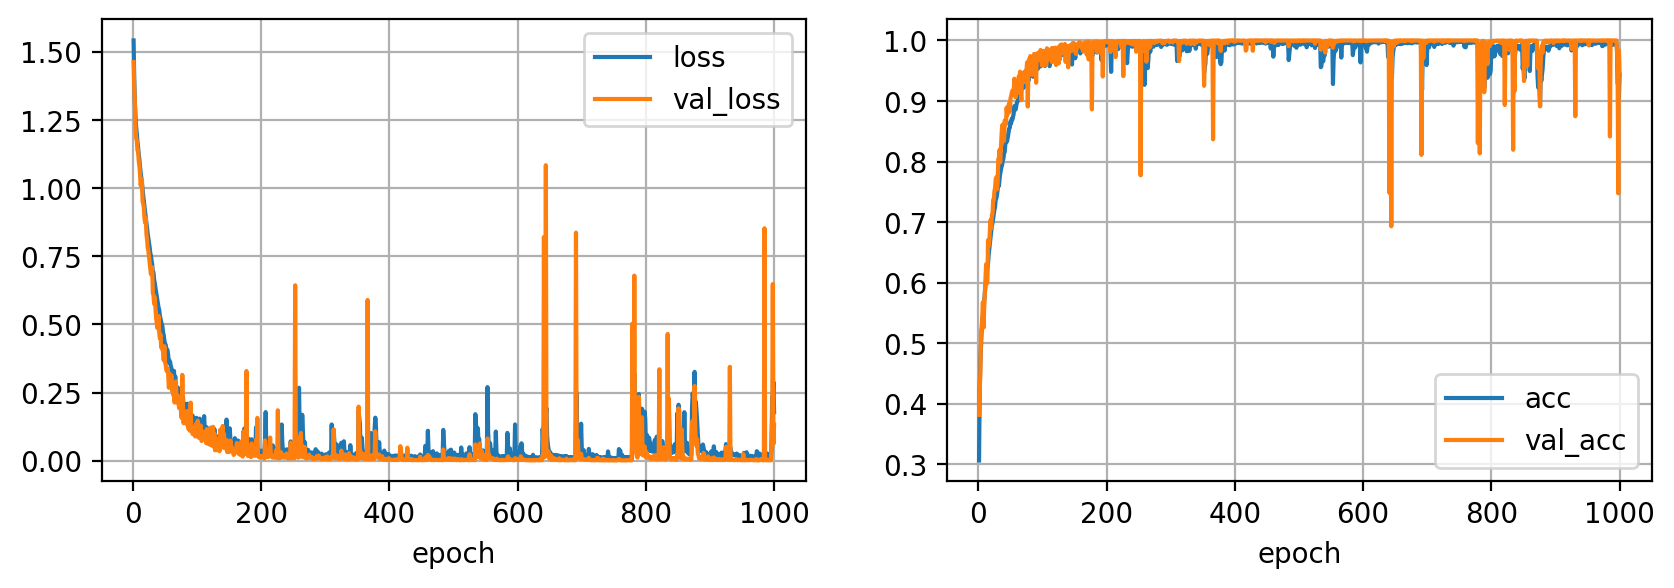

In [ ]:
mostrarGraficoEvaluacion(hist)